# Импорт библиотек

In [892]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import matplotlib.pyplot as plt
import nltk
import faiss
import string

# Считываю датасет

In [893]:
df = pd.read_parquet('train-00000-of-00001.parquet')
all_texts = list(set(df['question_1'].to_list() + df['question_2'].to_list())) # Всего 4567 уникальных вопроса
METRICS = {}
TOPN = 6
df.head(10)

,dr_id,question_1,question_2,label
0,1,After how many hour from drinking an antibioti...,I have a party tonight and I took my last dose...,1
1,1,After how many hour from drinking an antibioti...,I vomited this morning and I am not sure if it...,0
2,1,Am I over weight (192.9) for my age (39)?,I am a 39 y/o male currently weighing about 19...,1
3,1,Am I over weight (192.9) for my age (39)?,What diet is good for losing weight? Keto or v...,0
4,1,Aspirin allergy - is it worth getting a bracelet?,How much Aspirin can I take for my headache wi...,0
5,1,Aspirin allergy - is it worth getting a bracelet?,My friend told me about this bracelet for Aspi...,1
6,1,"At a doctor's visit, I hit my head against a b...",Is it okay if I use the same syringe for my in...,0
7,1,"At a doctor's visit, I hit my head against a b...","Today morning, I had an appointment with the d...",1
8,1,Been on antibiotics 4 5wks top high tooth dent...,"I am unable to get tooth extraction, my dentis...",1
9,1,Been on antibiotics 4 5wks top high tooth dent...,Why do I have black teeth? Should I take antib...,0


Сохраняю текст для инференса

In [894]:
with open('all_texts.txt', 'w', encoding="utf-8") as f_obj:
    text_row = "!!!!!".join(all_texts)
    f_obj.write(text_row)

# Функция для визуализации метрик

In [895]:
def metric_visual():
    x_labels = list(METRICS.keys())
    x = [i for i in range(len(x_labels))]
    y = list(METRICS.values())
    plt.plot(x, y)
    plt.xticks(x, x_labels)
    plt.xlabel('Model')
    plt.ylabel('Accuracy@5 (%)')
    plt.title('METRIC FOR MODELS')
    plt.grid(alpha=0.3)
    plt.show()

# Препроцессинг
Токенизация\
Использую помимо word_tokenize еще PorterStemmer

In [896]:
def tokenize(text):
    text = ''.join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stem = nltk.stem.PorterStemmer()
    stem_tokens = [stem.stem(token) for token in tokens]
    return stem_tokens

Векторизация

In [897]:
def preproc_df(text):
    vectorizer = CountVectorizer(tokenizer=tokenize,
                                 stop_words='english',
                                 max_features=3500)
    vectorizer.fit(all_texts)
    bow_cv = vectorizer.transform(text)
    bow_cv = TfidfTransformer().fit_transform(bow_cv)
    bow_cv = bow_cv.toarray()
    return bow_cv

q_12 = preproc_df(all_texts)
print(q_12.shape)

C:\Users\Артем Васильев\PycharmProjects\ya_ml_pycharm\venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Артем Васильев\PycharmProjects\ya_ml_pycharm\venv\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'som

(4567, 3500)


In [898]:
# dims = q_12.shape[1]
# n_cells = 5
# quantizer = faiss.IndexFlatL2(dims)
# idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
# idx_l2.train(np.ascontiguousarray(q_12).astype('float32'))
# idx_l2.add(np.ascontiguousarray(q_12).astype('float32'))
# candidate_number = 6
# D, I = idx_l2.search(np.ascontiguousarray(q_12).astype('float32'), candidate_number)
# print(I, D)

# Считаю соседей
В качестве подсчета соседей использую библиотеку faiss

In [899]:
index_base = faiss.IndexFlatL2(q_12.shape[1])
print(index_base.ntotal)  # пока индекс пустой
index_base.add(q_12)
print(index_base.ntotal)

D, I = index_base.search(q_12, TOPN)  # Возвращает результат: Distances, Indices

0
4567


Привожу датафреймы в массивы для подсчета метрик

In [900]:
result = []
for ind in I:
    row = []
    for i in ind:
        row.append(all_texts[i])
    result.append(row)

    
df_dict = df.to_dict()
df_mass = []
df = df[df['label'] == 1]
for i in range(len(df)):
    df_mass.append([df_dict['question_1'][i], df_dict['question_2'][i]])

# Accuracy @ 5

In [901]:
def accuracy_5(df_mass, result):
    counter = 0
    for row_df in df_mass:
        for row_res in result:
            if row_df[0] == row_res[0] and row_df[1] in row_res[1:]:
                counter += 1
                break
    metric = (counter / len(df_mass)) * 100
    print(f'PRED/TRUE:    {counter}/{len(df_mass)}\nACCURACY@5: {metric}')
    return metric

In [902]:
METRICS['Base'] = accuracy_5(df_mass, result)

PRED/TRUE:    1145/1524
ACCURACY@5: 75.13123359580052


Проверяю скрипт на кастомном вопросе

In [903]:
a = ['Can I drink alcohol every day?']
a = preproc_df(a)
topn = 5
D, I = index_base.search(a, topn)

for el in I[0]:
    print(all_texts[el])

C:\Users\Артем Васильев\PycharmProjects\ya_ml_pycharm\venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Артем Васильев\PycharmProjects\ya_ml_pycharm\venv\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'som

After how many hour from drinking an antibiotic can I drink alcohol?
Effects of drinking alcohol on the body fat?
I smoke and drink alcohol, is my sperm healthy? Can it last 7 days inside the uterus?
I usually smoke and drink alcohol, is my sperm healthy enough to last inside the uterus for 7 days or more? 
I have not drank alcohol for a year and 8 months now. Can recently drinking 0.06 pack a day affect my liver?


# Гипотеза №1
В тексте много сокращений. Идея - заменить сокращения полной формой

In [904]:
cuts = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example',
                       "etc": "et cetera"}
all_texts_copy = all_texts.copy()
for index, row in enumerate(all_texts_copy):
    for key, value in cuts.items():
        row = row.replace(key, value)
    all_texts_copy[index] = row

После форматирования текста создаю новую модель и ищу соседей

In [905]:
q_12 = preproc_df(all_texts_copy)
index_сuts = faiss.IndexFlatL2(q_12.shape[1])
index_сuts.add(q_12)
D, I = index_сuts.search(q_12, TOPN)  # Возвращает результат: Distances, Indices

Форматирую индексы в массивы строк для подсчета метрик

In [906]:
result = []
for ind in I:
    row = []
    for i in ind:
        row.append(all_texts_copy[i])
    result.append(row)

In [907]:
METRICS['Cuts'] = accuracy_5(df_mass, result)

PRED/TRUE:    932/1524
ACCURACY@5: 61.15485564304461


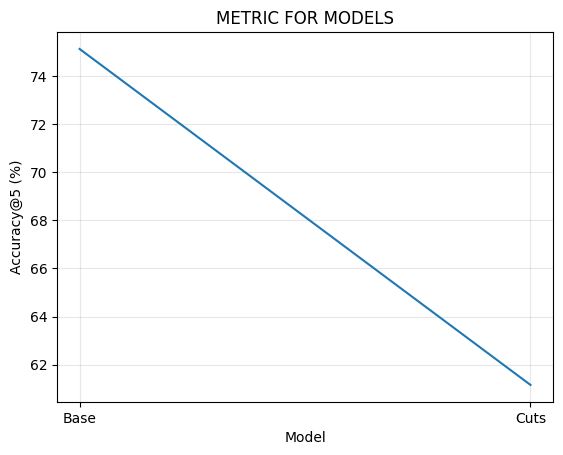

In [908]:
metric_visual()

Как можно заметить, метрика значительно упала (> 10 %)

# Гипотеза №2
Стоит попробовать вместо CountVectorizer использовать TfidfVectorizer

In [909]:
def preproc_df(text):
    vectorizer = TfidfVectorizer(tokenizer=tokenize,
                                 stop_words='english',
                                 max_features=3500)
    vectorizer.fit(all_texts)
    bow_cv = vectorizer.transform(text)
    tfidf = TfidfTransformer().fit_transform(bow_cv)
    tfidf = tfidf.toarray()
    return tfidf


q_12 = preproc_df(all_texts)
print(q_12.shape)

C:\Users\Артем Васильев\PycharmProjects\ya_ml_pycharm\venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Артем Васильев\PycharmProjects\ya_ml_pycharm\venv\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'som

(4567, 3500)


In [910]:
q_12 = preproc_df(all_texts)
index_tfvec = faiss.IndexFlatL2(q_12.shape[1])
index_tfvec.add(q_12)
D, I = index_tfvec.search(q_12, TOPN)  # Возвращает результат: Distances, Indices

In [911]:
result = []
for ind in I:
    row = []
    for i in ind:
        row.append(all_texts[i])
    result.append(row)

In [912]:
METRICS['TfVectorize'] = accuracy_5(df_mass, result)

PRED/TRUE:    1123/1524
ACCURACY@5: 73.68766404199475


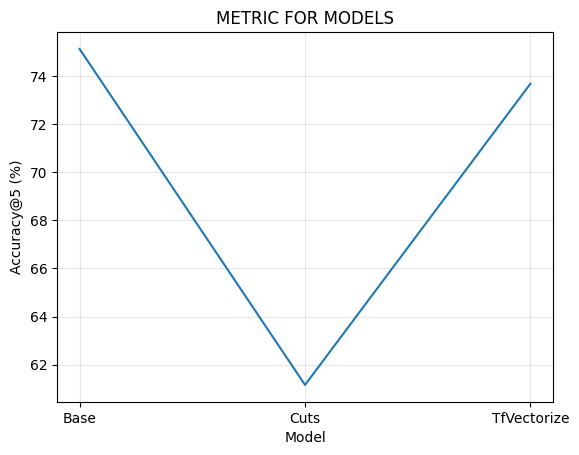

In [913]:
metric_visual()

Результаты лучше, чем с предыдущей гипотезой, но все равно не дотягивает до уровня базовой модели

# В качестве финальной модели буду использовать базовую модель, тк она показала лучшие метрики
Сохраняю модель в файл

In [914]:
from faiss import write_index
write_index(index_base, "mle_index.index")